# 🏷️ Pricing Optimization: Scenario 1 (The Foundation)
### *Dynamic Pricing based on Supply & Demand*

**The Concept:** The oldest law in economics is "Supply and Demand." However, adjusting prices isn't just about math; it's about strategy.
* If Demand is **High** and Inventory is **Low**, we have "Scarcity Power" $\rightarrow$ **Increase Price**.
* If Demand is **Low** and Inventory is **High**, we have "Overstock Risk" $\rightarrow$ **Decrease Price (Clearance)**.

**The Inputs:**
1.  **Demand Strength:** How much do people want it? ($0 - 100$ scale)
2.  **Inventory Level:** How much stock do we have? ($0 - 1000$ units)

**The Output:**
* **Price Adjustment:** Percentage change in price ($-20\%$ to $+20\%$).

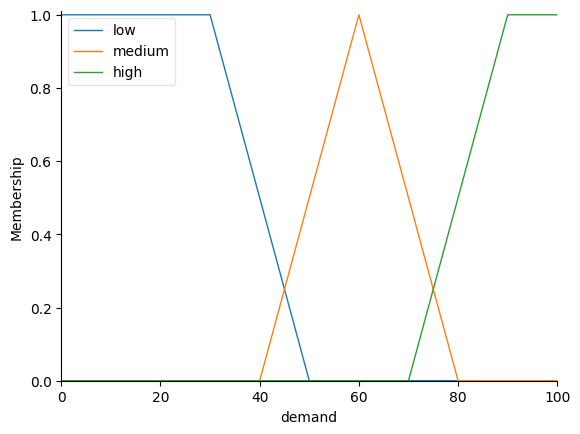

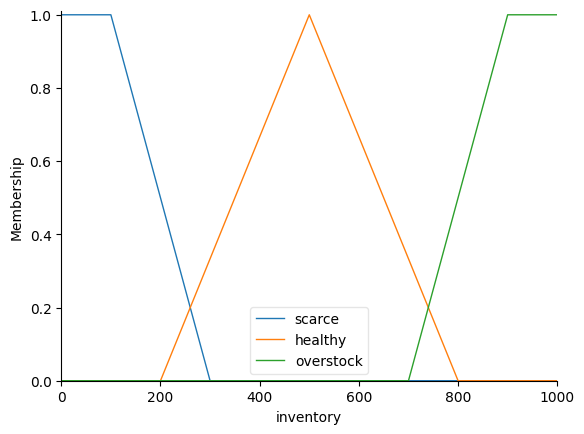

In [2]:
!pip install scikit-fuzzy -q
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# 1. Define Universes
demand = ctrl.Antecedent(np.arange(0, 101, 1), 'demand')
inventory = ctrl.Antecedent(np.arange(0, 1001, 1), 'inventory')
price_change = ctrl.Consequent(np.arange(-21, 22, 1), 'price_change')

# 2. Membership Functions (Precise Definition)
# Demand: We use Trapezoids for extremes to capture "Very Low" or "Very High" stability.
demand['low'] = fuzz.trapmf(demand.universe, [0, 0, 30, 50])
demand['medium'] = fuzz.trimf(demand.universe, [40, 60, 80])
demand['high'] = fuzz.trapmf(demand.universe, [70, 90, 100, 100])

# Inventory:
inventory['scarce'] = fuzz.trapmf(inventory.universe, [0, 0, 100, 300]) # Critical low stock
inventory['healthy'] = fuzz.trimf(inventory.universe, [200, 500, 800])
inventory['overstock'] = fuzz.trapmf(inventory.universe, [700, 900, 1000, 1000]) # Warehouse full

# Output: Price Adjustment (%)
price_change['clearance'] = fuzz.trapmf(price_change.universe, [-20, -20, -10, -5]) # Big discount
price_change['discount'] = fuzz.trimf(price_change.universe, [-10, -5, 0])
price_change['maintain'] = fuzz.trimf(price_change.universe, [-2, 0, 2]) # Keep steady
price_change['increase'] = fuzz.trimf(price_change.universe, [0, 5, 10])
price_change['surge'] = fuzz.trapmf(price_change.universe, [5, 10, 20, 20]) # Scarcity premium

# Visualization for Clarity
demand.view()
inventory.view()

### 🧠 The Rule Base: Economic Logic
We translate economic intuition into Fuzzy Rules.
* **The "Gold Mine" Rule:** If everyone wants it (High Demand) and we barely have any (Scarce Inventory), we can charge a premium (**Surge**).
* **The "Liquidate" Rule:** If nobody wants it (Low Demand) and our warehouse is bursting (Overstock), we must slash prices (**Clearance**).

| Demand | Inventory | Strategy | Price Action |
| :--- | :--- | :--- | :--- |
| High | Scarce | Maximize Profit | **Surge (+10 to +20%)** |
| High | Healthy | Normal Growth | **Increase (+5%)** |
| Medium | Healthy | Stability | **Maintain (0%)** |
| Low | Healthy | Stimulation | **Discount (-5%)** |
| Low | Overstock | Liquidation | **Clearance (-10 to -20%)** |

Recommended Price Adjustment: 13.71%


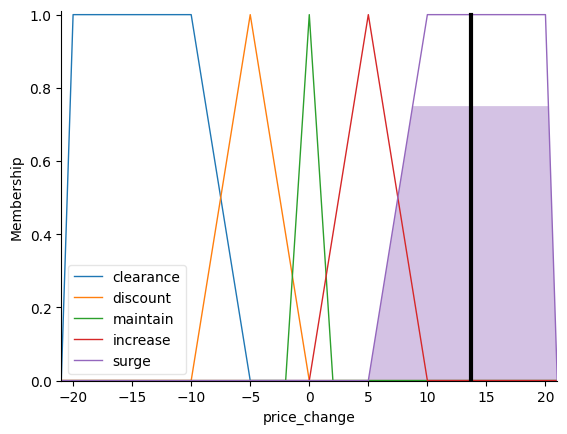

In [3]:
# 3. Define Rules
r1 = ctrl.Rule(demand['high'] & inventory['scarce'], price_change['surge'])
r2 = ctrl.Rule(demand['high'] & inventory['healthy'], price_change['increase'])
r3 = ctrl.Rule(demand['medium'] & inventory['healthy'], price_change['maintain'])
r4 = ctrl.Rule(demand['low'] & inventory['healthy'], price_change['discount'])
r5 = ctrl.Rule(demand['low'] & inventory['overstock'], price_change['clearance'])

# Corner Cases (Completing the Logic)
r6 = ctrl.Rule(demand['medium'] & inventory['scarce'], price_change['increase'])
r7 = ctrl.Rule(demand['medium'] & inventory['overstock'], price_change['discount'])
r8 = ctrl.Rule(demand['high'] & inventory['overstock'], price_change['maintain']) # Demand absorbs stock
r9 = ctrl.Rule(demand['low'] & inventory['scarce'], price_change['maintain']) # Niche market

# 4. Build System
pricing_ctrl = ctrl.ControlSystem([r1, r2, r3, r4, r5, r6, r7, r8, r9])
pricing_engine = ctrl.ControlSystemSimulation(pricing_ctrl)

# 5. Test Scenario: "Hot Product Running Out"
# Demand is 85/100 (High), Inventory is 150 units (Scarce)
pricing_engine.input['demand'] = 85
pricing_engine.input['inventory'] = 150

pricing_engine.compute()
print(f"Recommended Price Adjustment: {pricing_engine.output['price_change']:.2f}%")
price_change.view(sim=pricing_engine)

### 📊 Visualizing the Strategy
The 3D Surface below is essentially a **"Profit Map"**.
* The **Red Peaks** represent opportunities to increase profit margins.
* The **Blue Valleys** are where we must cut prices to generate cash flow.

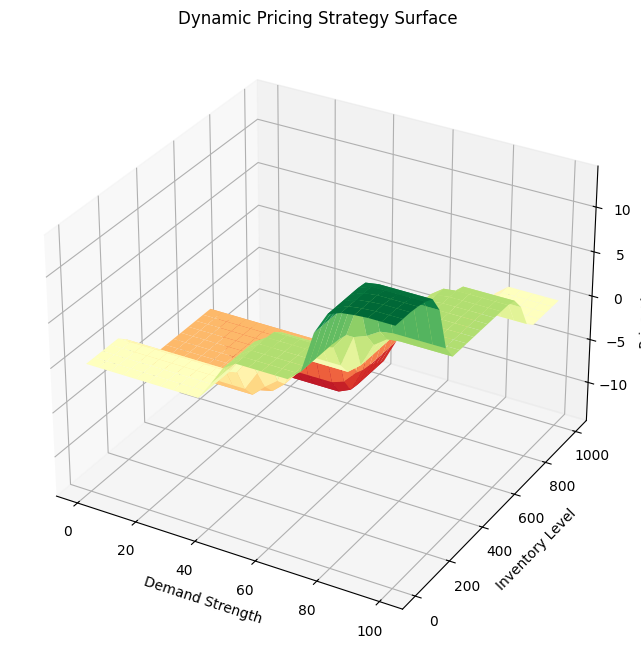

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Grid
x_dem = np.linspace(0, 100, 25)
y_inv = np.linspace(0, 1000, 25)
x, y = np.meshgrid(x_dem, y_inv)
z = np.zeros_like(x)

# Compute
for i in range(25):
    for j in range(25):
        pricing_engine.input['demand'] = x[i, j]
        pricing_engine.input['inventory'] = y[i, j]
        try:
            pricing_engine.compute()
            z[i, j] = pricing_engine.output['price_change']
        except:
            z[i, j] = 0

# Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, cmap='RdYlGn', edgecolor='none') # Red-Yellow-Green (Loss to Profit)

ax.set_title('Dynamic Pricing Strategy Surface')
ax.set_xlabel('Demand Strength')
ax.set_ylabel('Inventory Level')
ax.set_zlabel('Price Change (%)')
plt.show()

### 🕹️ Bonus: Interactive Profit Map
Static charts are flat; markets are dynamic. This interactive 3D model allows you to rotate the **Supply-Demand Landscape**.

* **Green Peaks:** High-margin opportunities where "Scarcity Power" allows for price surges.
* **Red Valleys:** Liquidation zones where "Inventory Velocity" is prioritized over margin.

In [5]:
import plotly.graph_objects as go

# We use the 'RdYlGn' scale: Red (Clearance) -> Yellow (Maintain) -> Green (Surge)
fig = go.Figure(data=[go.Surface(
    z=z, x=x, y=y,
    colorscale='RdYlGn',
    opacity=0.9
)])

# Clean Layout
fig.update_layout(
    title='Interactive Dynamic Pricing Surface',
    scene=dict(
        xaxis_title='Demand Strength',
        yaxis_title='Inventory Level',
        zaxis_title='Price Change (%)'
    ),
    width=800, height=700,
    margin=dict(l=40, r=40, b=40, t=80)
)

fig.show()

### 🎯 Result: Algorithmic Equilibrium
This model replaces "gut feeling" pricing with **logic-based elasticity**.

**Key Takeaway:** By mathematically balancing **Scarcity Power** against **Inventory Risk**, the system maximizes margins during high demand and protects cash flow during overstock. We don't just set prices; we react to the market's pulse in real-time.